In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from astroNN.nn.layers import MCDropout
import math
# np.random.seed(0)

### In this notebook, we use a compressed version of JLA compilation
#### First, we load the trained AutoEncoder

In [2]:
np.random.seed(0)

In [3]:
autoencoder = tf.keras.models.load_model('../models/autoencoderJLA.h5')
file2 = '../data/jla_binned_distances_31nodes_v1.txt'
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)

# shuffle = [x for x in range(len(data.values)) if x%2 == 0]
# comp = [x for x in range(len(data.values)) if x%2 ==1]
# shuffle.extend(comp)
shuffle = [0,1,2,3,4,5,6,7,8,30,28,26,24,22,20,9,10,12,14,16,18,29,27,25,23,21,19,17,15,13,11]



z = data.values[:,0][shuffle]
dl = data.values[:,1][shuffle]

# scalerdl = StandardScaler()
# scalerdl.fit(dl.reshape(-1, 1))
# dll = scalerdl.transform(dl.reshape((-1,1)))

nsize = len(syscov)
np.shape(syscov)
errors = np.diag(syscov).reshape(nsize,1)
errors = np.where(errors!= 0, np.log(errors), 0)

errors = errors[shuffle]
np.shape(errors)
len(data), len(errors)

(31, 31)

# FFNN

In [4]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]

# index = np.argsort(z)
zz = np.log(z)

# scalerz = StandardScaler()
# scalerz.fit(z.reshape(-1, 1))
# zz = scalerz.transform(z.reshape((-1,1)))

# scalerdl = StandardScaler()
# scalerdl.fit(dl.reshape(-1, 1))
# dll = scalerdl.transform(dl.reshape((-1,1)))
dll = dl.reshape(nsize, 1)


# scalererr = StandardScaler()
# scalererr.fit(errors.reshape(-1, 1))
# errscl = scalererr.transform(errors.reshape((-1,1)))

z_train, z_test = np.split(zz, indx)
y = np.concatenate((dll, errors), axis=1)
y_train, y_test = np.split(y, indx)
# y


In [6]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
#     x = MCDropout(0.01)(efirst)
    x = Dense(100, activation='relu')(efirst)
    x = MCDropout(0.001)(x)

    elast = Dense(2, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 5,402
Trainable params: 5,402
Non-trainable params: 0
_________________________________________________________________


In [7]:
model2_train = neural_model2.fit(z_train, y_train, batch_size=1,
                                    epochs=500,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/500
24/24 [==============================] - 0s 5ms/step - loss: 684.5328 - val_loss: 725.2549
Epoch 2/500
24/24 [==============================] - 0s 1ms/step - loss: 677.4497 - val_loss: 628.9418
Epoch 3/500
24/24 [==============================] - 0s 1ms/step - loss: 592.7044 - val_loss: 488.5505
Epoch 4/500
24/24 [==============================] - 0s 1ms/step - loss: 389.7163 - val_loss: 312.0280
Epoch 5/500
24/24 [==============================] - 0s 1ms/step - loss: 236.0336 - val_loss: 190.8937
Epoch 6/500
24/24 [==============================] - 0s 1ms/step - loss: 214.2773 - val_loss: 140.6056
Epoch 7/500
24/24 [==============================] - 0s 1ms/step - loss: 184.1529 - val_loss: 150.2755
Epoch 8/500
24/24 [==============================] - 0s 1ms/step - loss: 187.1279 - val_loss: 136.5093
Epoch 9/500
24/24 [==============================] - 0s 1ms/step - loss: 148.3734 - val_loss: 125.7100
Epoch 10/500
24/24 [==============================] - 0s 1ms/step - loss:

24/24 [==============================] - 0s 1ms/step - loss: 0.3214 - val_loss: 0.3183
Epoch 83/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3315 - val_loss: 0.2973
Epoch 84/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2673 - val_loss: 0.2056
Epoch 85/500
24/24 [==============================] - 0s 1ms/step - loss: 0.4292 - val_loss: 0.2464
Epoch 86/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3431 - val_loss: 0.2587
Epoch 87/500
24/24 [==============================] - 0s 1ms/step - loss: 0.4116 - val_loss: 0.3688
Epoch 88/500
24/24 [==============================] - 0s 1ms/step - loss: 0.4646 - val_loss: 0.3848
Epoch 89/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3258 - val_loss: 0.2862
Epoch 90/500
24/24 [==============================] - ETA: 0s - loss: 0.621 - 0s 1ms/step - loss: 0.3084 - val_loss: 0.5870
Epoch 91/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3631 - val_lo

24/24 [==============================] - 0s 1ms/step - loss: 0.1593 - val_loss: 0.0590
Epoch 164/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1930 - val_loss: 0.0557
Epoch 165/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1401 - val_loss: 0.1142
Epoch 166/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1378 - val_loss: 0.0959
Epoch 167/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1951 - val_loss: 0.0578
Epoch 168/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1489 - val_loss: 0.0949
Epoch 169/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2005 - val_loss: 0.0523
Epoch 170/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1545 - val_loss: 0.0415
Epoch 171/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1570 - val_loss: 0.1199
Epoch 172/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2193 - val_loss: 0.1961
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.1992 - val_loss: 0.0585
Epoch 245/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2574 - val_loss: 0.0594
Epoch 246/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2784 - val_loss: 0.2356
Epoch 247/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1889 - val_loss: 0.1323
Epoch 248/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2336 - val_loss: 0.1398
Epoch 249/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1650 - val_loss: 0.1336
Epoch 250/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1883 - val_loss: 0.1858
Epoch 251/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1454 - val_loss: 0.1079
Epoch 252/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.1555
Epoch 253/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2636 - val_loss: 0.1073
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.1371 - val_loss: 0.1667
Epoch 326/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1520 - val_loss: 0.0375
Epoch 327/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1211 - val_loss: 0.1048
Epoch 328/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1867 - val_loss: 0.0410
Epoch 329/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1344 - val_loss: 0.1295
Epoch 330/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1735 - val_loss: 0.0840
Epoch 331/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1420 - val_loss: 0.2441
Epoch 332/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2619 - val_loss: 0.0641
Epoch 333/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1510 - val_loss: 0.0421
Epoch 334/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1784 - val_loss: 0.0438
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.2253 - val_loss: 0.0477
Epoch 407/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3917 - val_loss: 0.1786
Epoch 408/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2180 - val_loss: 0.1430
Epoch 409/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2005 - val_loss: 0.0584
Epoch 410/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1759 - val_loss: 0.0930
Epoch 411/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1447 - val_loss: 0.0698
Epoch 412/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1838 - val_loss: 0.0418
Epoch 413/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1491 - val_loss: 0.0648
Epoch 414/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2430 - val_loss: 0.0841
Epoch 415/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1654 - val_loss: 0.1216
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.2219 - val_loss: 0.0457
Epoch 488/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1848 - val_loss: 0.0644
Epoch 489/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2289 - val_loss: 0.1722
Epoch 490/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1525 - val_loss: 0.0908
Epoch 491/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1826 - val_loss: 0.0482
Epoch 492/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1484 - val_loss: 0.0962
Epoch 493/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1922 - val_loss: 0.0552
Epoch 494/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2020 - val_loss: 0.1062
Epoch 495/500
24/24 [==============================] - 0s 1ms/step - loss: 0.1418 - val_loss: 0.0711
Epoch 496/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2692 - val_loss: 0.0801
Epoc

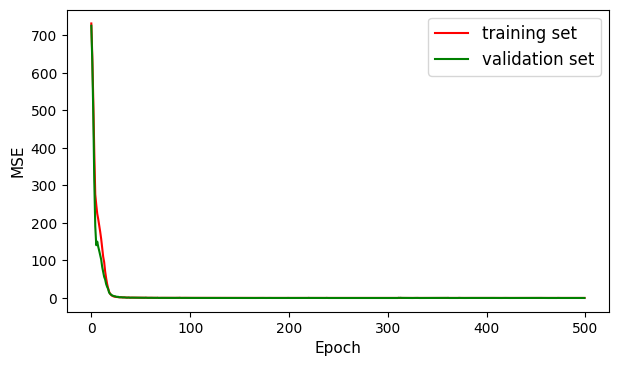

In [8]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('FFNN+MC-DO', fontsize=8)

plt.savefig('loss_dropoutJLA2.png')

In [9]:
file3 = 'fake_binned_JLA2TEST1.dat'
data3 = pd.read_csv(file3, names=['z', '$D_L$'], sep = " ", skiprows=3)

# x_test = np.log(data.values[:,0])
x_test = zz
# dl = data.values[:,1:][shuffle]
np.shape(x_test)

(31,)

In [10]:
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
# x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100# Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))

for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(x_test)
    

prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)

# get mean results and its varience
predictions_dl = prediction_mc_dropout[:,0]
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))
predictions_err = np.exp(prediction_mc_dropout[:,1].reshape(-1,1))
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))


sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

np.shape(predictions), np.shape(predictions_dl), np.shape(predictions_err), np.shape(prediction_mc_dropout)


((100, 31, 2), (31,), (31, 1), (31, 2))

In [11]:
np.shape(prediction_mc_dropout), np.shape(predictions_dl), np.shape(predictions_err)
# predictions_err

((31, 2), (31,), (31, 1))

In [12]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43



In [13]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

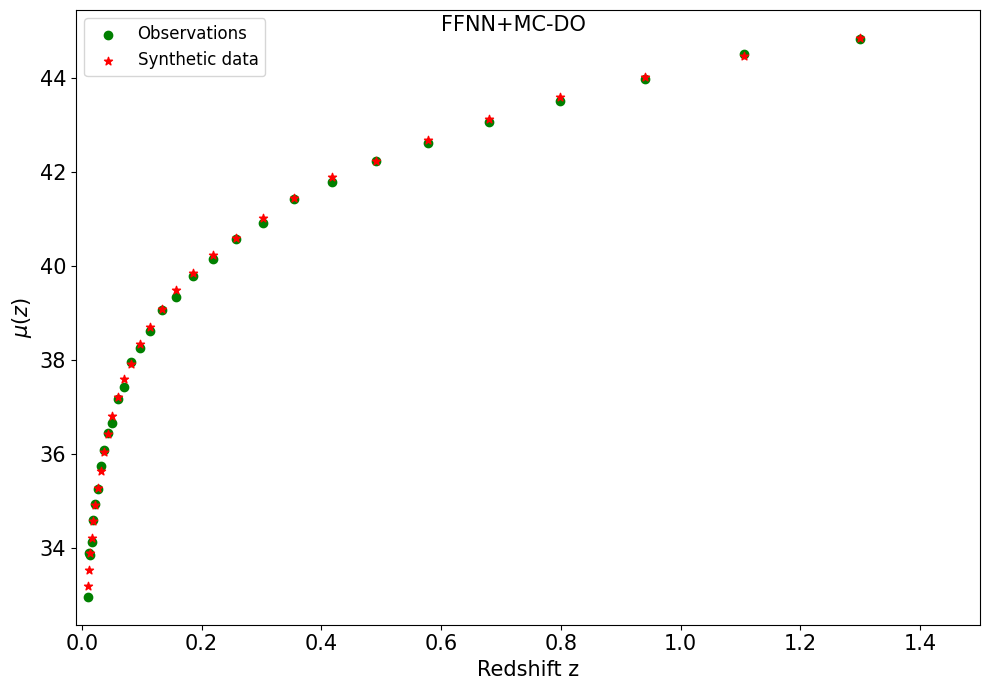

In [14]:
# Plotting
# dlfake = scalerdl.inverse_transform(prediction_mc_dropout[:,0].reshape(-1,1))
# dlfake = prediction_mc_dropout[:,0]
plt.figure(figsize=(10, 7), dpi=100)
# print(np.shape(dlfake))

# fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
# sigma = np.sqrt(std_mc_dropout.reshape(31,))

plt.scatter(z, dl, c='g', label='Observations')
# plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.scatter(z, predictions_dl, marker='*', c='r', label='Synthetic data')

# plt.errorbar(x_test, dlfake, yerr=sigma
#              , markersize=10, fmt='.', 
#              ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='r',
#              label='Synthetic data')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(-0.01, np.max(z)+0.2)
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(0, np.max(z))
plt.xticks(fontsize=15)
plt.text(0.6, 45, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

plt.legend(loc='upper left', fontsize=12)
# plt.show()
plt.savefig('DL_dropoutb2.png')

In [17]:
index = np.argsort(z)
dlfake = predictions_dl
fake_data2 = np.stack((z[index], dlfake.reshape(31,)[index]), axis=1)


np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')
# np.savetxt("errors_JLA_DO.dat", predictions_err, delimiter= " ", header="#fake statistical errors", fmt='%1.9f')

In [18]:
tf.keras.models.save_model(neural_model2, '..models/FFNN_JLA_DO.h5' )